# <center>Pairs Selection Framework </center>
## Abstract 
Trying to Implement the pairs selection framework from http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf <br>
## Structure of the notebook body
1. Importing data <br>
2. Preprocessing <br>
3. (Part A) PCA <br>
4. (Part B) OPTICS clustering <br>
5. (Part C) Screening for approriate pairs using 4 criterions <br>
6. Analysis and Discussion <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_import import ImportData
import os

plt.style.use('ggplot')

##  1. Importing Data
Using 10 years of daily closing price of stocks from 400 companies for demostration purpose. Companies chosen randomly from S&P 500. The user may load other data as needed, including those with intraday prices. <br>
Chose 400 instead of all SP500 companies because one may use the rest for furthur evaluation and testing.<br>

Note: End of the day price for stocks may not be the best for this demonstration since the author uses 5-min intraday data on ETFs. The author did provide ETFs data he uses however so far I found no free way to get 10 years of 5-min intraday data for SP500 stocks.

In [3]:
np.random.seed(1)
ID = ImportData()
# choose 400 stocks from SP500 randomly
tickers = list(np.random.choice(ID.get_sp500_tickers(), 400))
start_date = '2010-11-01'
end_date = '2020-10-10'
interval = '1d'

# get end of the day closing price
price_df = ID.get_price_data(tickers, start_date, end_date, interval)

# remove stocks with 100 or more missing data
price_df = ID.remove_nuns(df=price_df, threshold=100)

returns_df = ID.get_returns_data(price_df) # calculate returns
tickers = returns_df.columns # update tickers, dtype = list
dates = returns_df.index # dtype = pd.indexes.datetimes.DatetimeIndex

# save to csv
returns_df.to_csv('returns_10y_SP500_sample.csv')

[*********************100%***********************]  285 of 285 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted


In [4]:
# Import Data, if you have data available
#returns_df = pd.read_csv('returns_10y_SP500_sample.csv')
#tickers = returns_df.columns[1:]
#dates = returns_df['Date']

## 2. Preprocessing
1. standardizing <br>
2. imputation using KNN (K-nearest neighbor)<br>

Note: sklearn will turn pandas dataframes into numpy arrays. NumPy array will be the form we work with majorly throughout the notebook. Thus instead of using the ticker to refer to each asset, we will use an integer, which can be easily translated back to the ticker.

In [5]:
# standardizing 
from sklearn.preprocessing import scale
returns_scaled = scale(returns_df.iloc[:, 1:], axis=0) # dtype = np.ndarray

# imputation using KNN mean value
from sklearn.impute import KNNImputer
imp_mean = KNNImputer()
returns_transformed = imp_mean.fit_transform(returns_scaled) # dtype = np.ndarray

## 3. PCA (Part A)
Hyperparameter:<br>
dim(PCA) = 15, consistent with the article.

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
returns_PCA = pca.fit_transform(returns_transformed.transpose()) # dtype = np.ndarray

## 4. OPTICS Clustering (Part B)
Hyperparameter:<br>
min_samples = 5.<br>

In [7]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=5)
optics.fit(returns_PCA)

cluster_labels = optics.labels_ # dtype = list, index is asset
num_clusters = len(set(cluster_labels)) # number of clusters
all_clusters = np.unique(cluster_labels) # all cluster labels

# put every asset under its cluster label, in a dict asset_cluster_dict:
#  key: cluster label, dtype = int
#  value: asset indicies, dtype = list (of int)
cluster_asset_dict = {label: [] for label in all_clusters}
for asset_index, label in enumerate(cluster_labels):
    cluster_asset_dict[label].append(asset_index)
    
# values for clusters and assets for further analysis, without the noise cluster
## all cluster labels, not including the noise cluster
clusters_no_noise = np.delete(all_clusters, np.where(all_clusters == -1))
## all clusters' size, not including the noise cluster
cluster_size_no_noise = [len(cluster_asset_dict[cluster])
                         for cluster in clusters_no_noise]
## all assets that are not in the noise cluster
available_assets = []
for cluster in clusters_no_noise:
    available_assets += cluster_asset_dict[cluster]

### Visualize clusters in plots 
Note: When working with subcollection of SP500 with EOD data, the clustering algo think most as noise (label = -1). Use data with finer grid may be better.

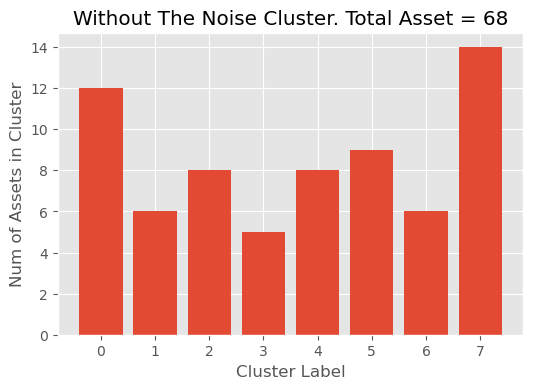

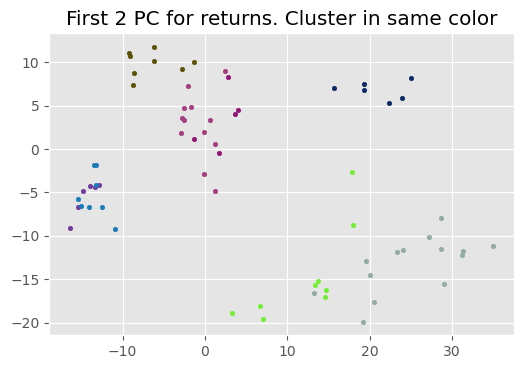

In [8]:
# bar plot
plt.figure(dpi=100)
plt.bar(clusters_no_noise, cluster_size_no_noise)
plt.xlabel('Cluster Label')
plt.ylabel('Num of Assets in Cluster')
plt.title('Without The Noise Cluster. Total Asset = {}'.format(len(available_assets)))
plt.show()

# cluster w.r.t. the two principle components
colors = {cluster: np.random.rand(3) for cluster in clusters_no_noise}
plt.figure(dpi=100)
for asset in available_assets:
    plt.scatter(returns_PCA[asset, 0], returns_PCA[asset, 1], s=10,
                color=colors[cluster_labels[asset]])

plt.title('First 2 PC for returns. Cluster in same color')
plt.show()

## 5. Pairs Selecting (Part C) 
1. Engle-Granger Test for cointegration: <br>
    a. For each pair $(s1,s2)$ and its reverse $(s2,s1)$, keep the one with lower $t$ stats.<br>
    b. Keep certain percentile of pairs ranked wrt their t-stats.<br>
2. Hurst Exponent $H$: Keep the pairs with (spread) $H<0.5$ for mean-reversion. <br>
3. Halflife: Keep the pairs with (spread) halflife in between $1$ day and $1$ year. <br>
4. Minimum number of crossing mean in a year: Keep the pairs with (spread) crossing its mean $12$ times a year.<br>

Most of the parameters can be adjusted.

In [9]:
from calculations import Screen
Scrn = Screen()
returns_dict = returns_transformed # key: asset (int), value: returns series 

# 0. Find all possible combinations of pairs within each cluster,
# then put all available pairs in all_pairs.
# Each step of screening, all_pairs will decrease its size.

## cluster_asset_dict_no_noise
##     key: cluster label, dtype = int
##     value: pairs available in the cluster, dtype = list (of tuples)
## all_pairs: list of tuples. All avaible pairs formed within each cluster.
cluster_asset_dict_no_noise = {cluster: cluster_asset_dict[cluster]
                               for cluster in clusters_no_noise}
cluster_pairs_dict, all_pairs = Scrn.find_cluster_pairs(
    cluster_asset_dict=cluster_asset_dict_no_noise,
    return_all_pairs=True)

In [11]:
# 1. Engle-Granger
## percentile: keep the pairs lower than the percentile w.r.t t-stats;
## i.e., 0 keeps none, 100 keeps all pairs
all_pairs_EG = Scrn.eg_screen(returns_dict=returns_dict,
                              all_pairs=all_pairs,
                              keep_percent=95)

print('pairs went from {} to {}'.format(len(all_pairs), len(all_pairs_EG)))

pairs went from 578 to 549


In [12]:
# 2. Hurst
pair_spread_dict = Scrn.find_pair_spread_dict(returns_dict, all_pairs_EG)
all_pairs_H = Scrn.hurst_screen(pair_spread_dict=pair_spread_dict,
                                all_pairs=all_pairs_EG,
                                threshold=0.5)

print('pairs went from {} to {}'.format(len(all_pairs_EG), len(all_pairs_H)))

pairs went from 549 to 433


In [13]:
# 3. Half life
lower_bound = 0.7
upper_bound = 250 # 250 trading days a year
all_pairs_halflife = Scrn.half_life_screen(lower_bound, upper_bound, all_pairs_H,
                                     pair_spread_dict=pair_spread_dict)

print('pairs went from {} to {}'.format(len(all_pairs_H), len(all_pairs_halflife)))

pairs went from 433 to 90


In [14]:
# 4. Min num of crosses with mean (roughly) in a year
min_num_cross = 12
intraday_amount = 1 # how many data per day
days_per_year = 250
all_pairs_mincross = Scrn.min_cross_screen(all_pairs=all_pairs_halflife,
                                           pair_spread_dict=pair_spread_dict,
                                           min_num_cross=min_num_cross,
                                           intraday_amount=1,
                                           days_per_year=days_per_year)

print('pairs went from {} to {}'.format(len(all_pairs_halflife), len(all_pairs_mincross)))

pairs went from 90 to 90


## Conclusion
The proposed framework does seem to work. The number of pairs left for a trader to handle is much less compared to a liberal combination of the stocks universe, especially the PCA and OPTICS clutering part. However there are multiple issues encountered when selecting pairs, as discussed in the section below. Some of these issues might be fixable or greatly improved when using a finer grid of data, as the author did.

## Issues Discussion
1. Most of the t-stats from Engle-Granger test are really small, around -15. Comparing t-stats at this small value may not be meaningful. <br>
2. Most pair spreads half life are around 0.4-0.8. It can be seen from one pair's spread plot and also the quantile plot. The author mentioned using lower bound 1 for half life and none of the half life in my stocks pairs exceeded 1.<br>
3. Similarly, the spreads seem to cross its mean (very close to 0 in general) extremely often. Hence the minimum number of crosses requirement barely trim away any pairs.<br>

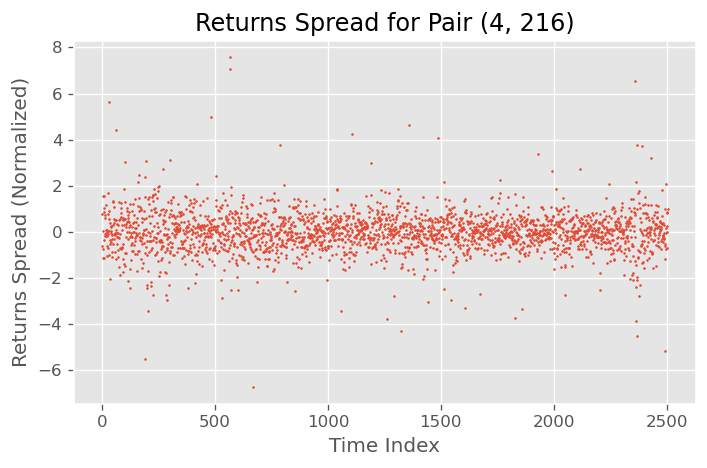

In [15]:
# returns spread plot for a pair
pair = all_pairs_mincross[0]
time_index = np.arange(len(pair_spread_dict[pair]))
plt.figure(dpi=120)
plt.scatter(time_index, pair_spread_dict[pair],s=1)
plt.xlabel('Time Index')
plt.ylabel('Returns Spread (Normalized)')
plt.title('Returns Spread for Pair {}'.format(pair))
plt.tight_layout()
plt.show()

# quantile plot for half life


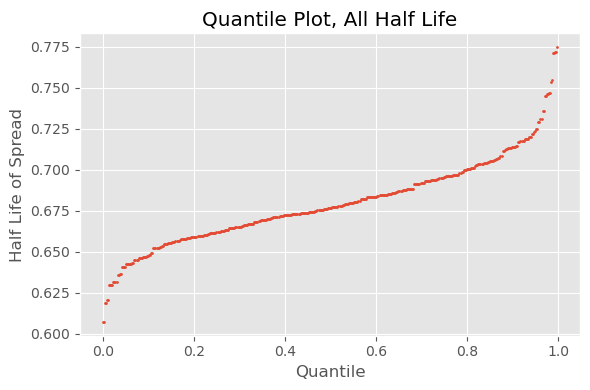

In [16]:
_, pair_halflife_dict = Scrn.half_life_screen(lower_bound=0, 
                                              upper_bound=250, 
                                              all_pairs=all_pairs_H,
                                              pair_spread_dict=pair_spread_dict,
                                              return_pair_halflife_dict=True)
halflife_sorted = np.sort(list(pair_halflife_dict.values()))
dummy_index = np.arange(len(halflife_sorted))
quantile_index = [index/len(dummy_index) for index in dummy_index]

plt.figure(dpi=100)
plt.scatter(quantile_index, halflife_sorted, s=2)
plt.xlabel('Quantile')
plt.ylabel('Half Life of Spread')
plt.title('Quantile Plot, All Half Life')
plt.tight_layout()
plt.show()